<ipython-input-31-753a54ff8fae>:64: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data1 = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.4], [0.6, 1]], size=100)


Weights: [0.4954099 0.5045901]
Means: [[0.07482879 0.09154855]
 [1.89595027 3.12870771]]
Covariances: [[[ 0.83876375  0.25882435]
  [ 0.25882435  0.69793292]]

 [[ 1.08398621 -0.76685296]
  [-0.76685296  0.9781861 ]]]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


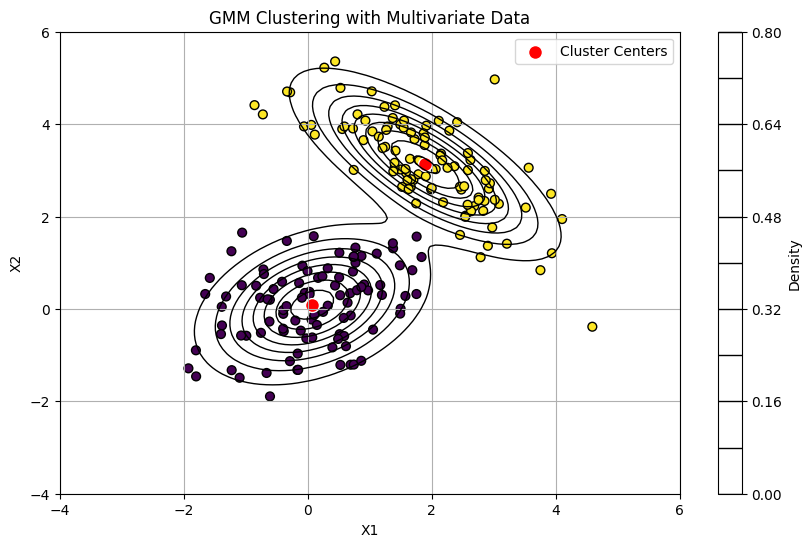

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

class GMM:
    def __init__(self, n_components=1, max_iter=100, tol=1e-4, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.weights = None
        self.means = None
        self.covariances = None

    def _initialize_parameters(self, X):
        np.random.seed(self.random_state)
        n_samples, _ = X.shape
        # Initialize weights uniformly
        self.weights = np.ones(self.n_components) / self.n_components
        # Randomly select data points as initial means
        random_indices = np.random.choice(n_samples, size=self.n_components, replace=False)
        self.means = X[random_indices]
        # Initialize covariances as identity matrices
        self.covariances = np.tile(np.identity(X.shape[1]), (self.n_components, 1, 1))

    def _compute_likelihood(self, X):
        likelihood = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            diff = X - self.means[k]
            exponent_term = -0.5 * np.sum(np.dot(diff, np.linalg.inv(self.covariances[k])) * diff, axis=1)
            likelihood[:, k] = np.exp(exponent_term) / np.sqrt(np.linalg.det(self.covariances[k]))
        return likelihood

    def fit(self, X):
        self._initialize_parameters(X)
        prev_log_likelihood = None
        for _ in range(self.max_iter):
            # E-step: compute responsibilities
            likelihood = self._compute_likelihood(X)
            responsibilities = likelihood * self.weights
            responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
            # M-step: update parameters
            N_k = np.sum(responsibilities, axis=0)
            self.weights = N_k / X.shape[0]
            self.means = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]
            for k in range(self.n_components):
                diff = X - self.means[k]
                self.covariances[k] = np.dot(diff.T * responsibilities[:, k], diff) / N_k[k]
            # Compute log likelihood
            log_likelihood = np.sum(np.log(np.sum(likelihood * self.weights, axis=1)))
            # Check for convergence
            if prev_log_likelihood is not None and np.abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
            prev_log_likelihood = log_likelihood

    def predict(self, X):
        likelihood = self._compute_likelihood(X)
        return np.argmax(likelihood * self.weights, axis=1)


# Example usage:
# Sample data generation
np.random.seed(42)
data1 = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.4], [0.6, 1]], size=100)
data2 = np.random.multivariate_normal(mean=[2, 3], cov=[[1, -0.7], [-0.7, 1]], size=100)
X = np.vstack([data1, data2])

# GMM initialization and training
gmm = GMM(n_components=2, random_state=42)
gmm.fit(X)

# Predictions
predictions = gmm.predict(X)

# Accessing parameters of the trained GMM
print("Weights:", gmm.weights)
print("Means:", gmm.means)
print("Covariances:", gmm.covariances)
print("Predictions:", predictions)

# Plotting the data and GMM clusters
x = np.linspace(-4, 6, 100)
y = np.linspace(-4, 6, 100)
X_grid, Y_grid = np.meshgrid(x, y)
XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T
Z = np.zeros_like(X_grid)

for k in range(gmm.n_components):
    diff = XX - gmm.means[k]
    exponent_term = -0.5 * np.sum(np.dot(diff, np.linalg.inv(gmm.covariances[k])) * diff, axis=1)
    likelihood = np.exp(exponent_term) / np.sqrt(np.linalg.det(gmm.covariances[k]))
    Z += gmm.weights[k] * likelihood.reshape(X_grid.shape)

plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=predictions, s=40, cmap='viridis', edgecolors='k')
plt.contour(X_grid, Y_grid, Z, levels=10, linewidths=1, colors='k', linestyles='solid')
plt.colorbar(label='Density')

plt.scatter(gmm.means[:, 0], gmm.means[:, 1], marker='o', c='r', s=100, edgecolors='w', label='Cluster Centers')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('GMM Clustering with Multivariate Data')
plt.legend()
plt.grid(True)
plt.show()